<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Load Modules

In [170]:
!pip install -q import_ipynb

In [171]:
# utils
import os, sys, warnings, itertools
import import_ipynb
import tarfile
import joblib
import random
import pandas as pd
import numpy as np
from pprint import pprint
# colab
from google.colab import drive
# sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     cross_val_predict,
                                     GridSearchCV
                                     )
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import (confusion_matrix,
                             precision_score,
                             recall_score,
                             f1_score,
                             accuracy_score,
                             precision_recall_curve,
                             PrecisionRecallDisplay,
                             roc_auc_score,
                             roc_curve
                             )
# vis
import seaborn as sns
import matplotlib.pyplot as plt

### Settings

In [172]:
warnings.filterwarnings("ignore")

In [173]:
%matplotlib inline

In [174]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [175]:
working_path = os.path.abspath(os.path.join("/content/drive/MyDrive/Jupyter Notebooks/"))
os.chdir(working_path)

In [176]:
# load MachineLearningUtils
from MachineLearningUtils import *

## Model Developement - Clf Five or Not

### Understand Data

In [177]:
mnist = None
data_path = os.path.join(working_path, "Inputs/mnist.pkl")
if os.path.exists(data_path):
    mnist = joblib.load(data_path)
else:
    mnist = fetch_openml("mnist_784", version=1)
    joblib.dump(mnist, data_path)
pprint(mnist.keys(), compact=True)

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [178]:
# load data
X, y = mnist.data, mnist.target.to_frame()
y.columns = ['target']

In [179]:
num_samples = 1000
X = X.sample(n=num_samples, random_state=1)
y = y.sample(n=num_samples, random_state=1)
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [180]:
display_df(X)

Dataframe:  
num_rows = 1,000 
num_cols = 784


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 6.0 MB


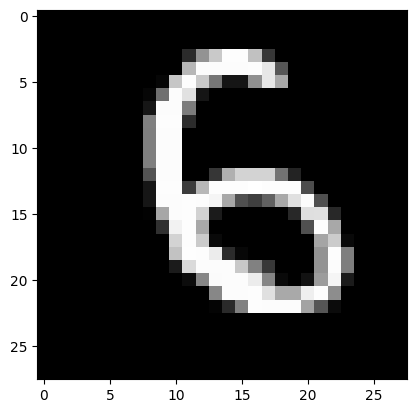

In [181]:
pixel_size = int(np.sqrt(X.shape[1]))
img = X.iloc[0].to_numpy().reshape(pixel_size, pixel_size)
plt.imshow(img, cmap="gray")

In [182]:
pprint(y['target'].dtype)

CategoricalDtype(categories=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], ordered=False, categories_dtype=object)


In [183]:
y['target'] = y['target'].astype(np.uint8)
display_df(y)

Dataframe:  
num_rows = 1,000 
num_cols = 1


,target
0,6
1,2
2,7
3,5
4,7


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  1000 non-null   uint8
dtypes: uint8(1)
memory usage: 1.1 KB


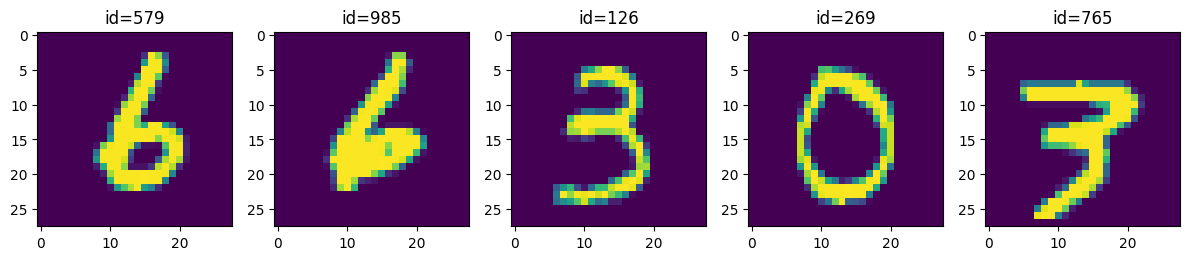

In [184]:
random_img = [random.randint(0, len(X)) for _ in range(5)]
num_rows = 1
num_cols = 5
fig = plt.figure(figsize=(12,14))
for img_num in range(num_rows*num_cols):
    ax = fig.add_subplot(num_rows, num_cols, img_num+1)
    index = random_img[img_num]
    image = X.loc[index, :].to_numpy().reshape(pixel_size, pixel_size)
    ax.imshow(image)
    ax.set_title("id={}".format(index))
plt.tight_layout()

### Define Train and Test Sets

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=2
                                                    )

In [186]:
y_train = np.where(y_train["target"] == 5, 1, 0)
y_test = np.where(y_test["target"] == 5, 1, 0)

### Imputation

In [187]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### SGDClassifier

In [188]:
sgd_clf = SGDClassifier(random_state=42, loss="log_loss")
sgd_clf.fit(X_train, y_train)

SGDClassifier(loss='log_loss', random_state=42)

In [189]:
pprint(sgd_clf._get_param_names())

['alpha',
 'average',
 'class_weight',
 'early_stopping',
 'epsilon',
 'eta0',
 'fit_intercept',
 'l1_ratio',
 'learning_rate',
 'loss',
 'max_iter',
 'n_iter_no_change',
 'n_jobs',
 'penalty',
 'power_t',
 'random_state',
 'shuffle',
 'tol',
 'validation_fraction',
 'verbose',
 'warm_start']


In [190]:
print("Num. of classes:", sgd_clf.classes_)
print("Num. of features:", sgd_clf.n_features_in_)

Num. of classes: [0 1]
Num. of features: 784


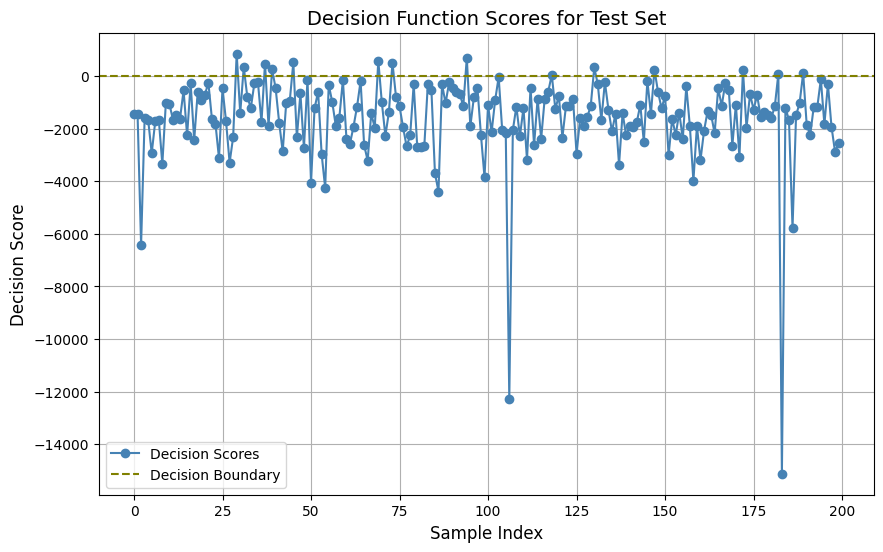

In [191]:
decision_scores = sgd_clf.decision_function(X_test)
plt.figure(figsize=(10, 6))
plt.plot(decision_scores, marker='o', linestyle='-', color='steelblue', label='Decision Scores')
plt.axhline(y=0, color='olive', linestyle='--', label='Decision Boundary')  # Add this line
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Decision Score', fontsize=12)
plt.title('Decision Function Scores for Test Set', fontsize=14)
plt.grid(True)
plt.legend(fontsize=10)
plt.show()

In [192]:
for attr in sgd_clf.__dict__:
    print(f"{attr}: {getattr(sgd_clf, attr)}")

loss: log_loss
penalty: l2
learning_rate: optimal
epsilon: 0.1
alpha: 0.0001
C: 1.0
l1_ratio: 0.15
fit_intercept: True
shuffle: True
random_state: 42
verbose: 0
eta0: 0.0
power_t: 0.5
early_stopping: False
validation_fraction: 0.1
n_iter_no_change: 5
warm_start: False
average: False
max_iter: 1000
tol: 0.001
class_weight: None
n_jobs: None
coef_: [[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.         -17.16789289
  -17.16789289 -17.16789289   0.           0.         -17.16789289
  -11.5258893  -16.1040028   -1.40760425 -17.16789289 -17.16789289
  -17.16789289   0.           0.           0.           0.
    0.           0.           0.     

In [193]:
methods = [method for method in dir(sgd_clf) if callable(getattr(sgd_clf, method))]
pprint(methods)

['__class__',
 '__delattr__',
 '__dir__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '_allocate_parameter_mem',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_check_proba',
 '_fit',
 '_fit_binary',
 '_fit_multiclass',
 '_get_default_requests',
 '_get_doc_link',
 '_get_learning_rate_type',
 '_get_loss_function',
 '_get_metadata_request',
 '_get_param_names',
 '_get_penalty_type',
 '_get_tags',
 '_make_validation_score_cb',
 '_make_validation_split',
 '_more_tags',
 '_more_validate_params',
 '_partial_fit',
 '_predict_proba_lr',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 '_validate_params',
 'decision_function',
 'densify',
 'fit',
 'ge

In [194]:
sgd_model_score = cross_val_score(sgd_clf,
                                  X_train,
                                  y_train,
                                  cv=10,
                                  scoring="accuracy")

print("Cross-validation scores:", sgd_model_score)
print("Mean accuracy:", sgd_model_score.mean())

Cross-validation scores: [0.9625 0.95   0.95   0.925  0.925  0.95   0.9375 0.925  0.9375 0.975 ]
Mean accuracy: 0.94375


### Naive Model

In [195]:
class NaiveModel(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        random_predictions = np.random.randint(0, 2, size=(len(X), 1))
        return random_predictions.astype(bool)

In [196]:
base_model = NaiveModel()
base_model.fit(X_train)

In [197]:
naive_model_score = cross_val_score(base_model,
                                    X_train,
                                    y_train,
                                    cv=10,
                                    scoring="accuracy")

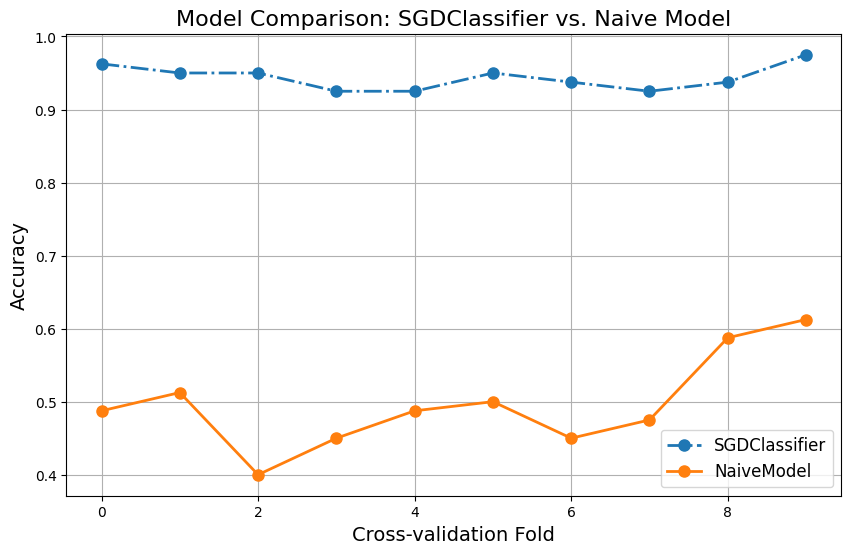

In [198]:
plt.figure(figsize=(10, 6))
plt.plot(sgd_model_score, "o-.", label="SGDClassifier", markersize=8, linewidth=2)
plt.plot(naive_model_score, "o-", label="NaiveModel", markersize=8, linewidth=2)
plt.title("Model Comparison: SGDClassifier vs. Naive Model", fontsize=16)
plt.xlabel("Cross-validation Fold", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

### Predictions

In [199]:
pred_train = cross_val_predict(sgd_clf, X_train, y_train, cv=10)

Confusion matrix no normalization
[[710  11]
 [ 34  45]]


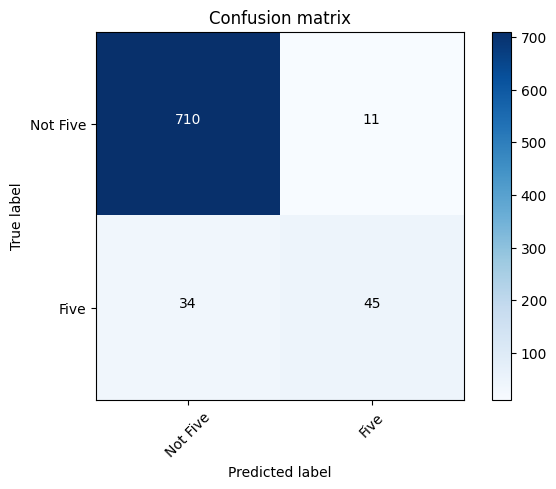

In [200]:
cm = confusion_matrix(y_train, pred_train)
plot_conf_matrix(cm, classes=["Not Five", "Five"], normalize=False, title="Confusion matrix", cmap=plt.cm.Blues)

In [201]:
print("accuracy: {}".format(accuracy_score(y_train, pred_train)))
print("precision: {}".format(precision_score(y_train, pred_train)))
print("recall: {}".format(recall_score(y_train, pred_train)))
print("f1: {}".format(f1_score(y_train, pred_train)))

accuracy: 0.94375
precision: 0.8035714285714286
recall: 0.569620253164557
f1: 0.6666666666666666


In [202]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=10, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
thresholds = np.insert(thresholds, 0, thresholds[0])
df = pd.DataFrame({"precision": precisions, "recalls": recalls, "thresholds": thresholds})
df

,precision,recalls,thresholds
0,0.098750,1.000000,-5629.392097
1,0.098874,1.000000,-5629.392097
2,0.098997,1.000000,-4997.530740
3,0.099122,1.000000,-4731.781807
4,0.099246,1.000000,-4721.920161
...,...,...,...
796,1.000000,0.050633,868.498641
797,1.000000,0.037975,868.779083
798,1.000000,0.025316,913.612976
799,1.000000,0.012658,953.152475


<Figure size 1000x600 with 0 Axes>

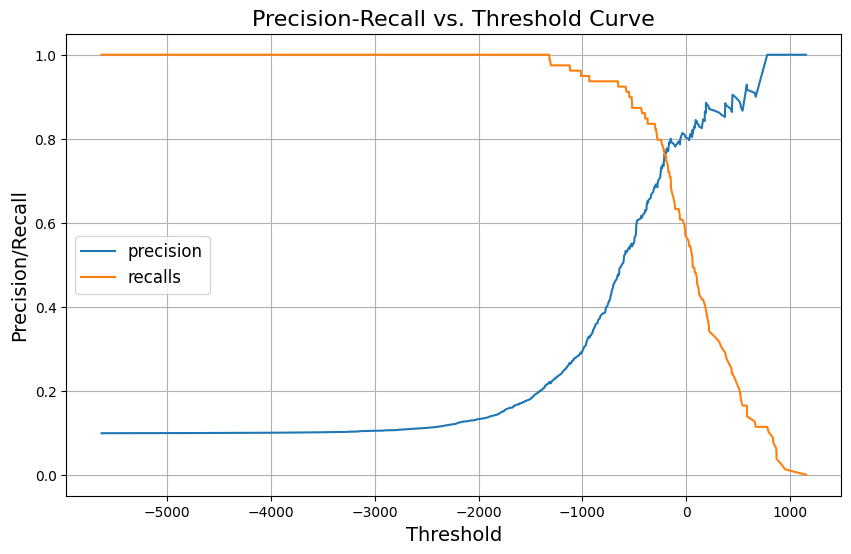

In [203]:
plt.figure(figsize=(10, 6))
df.plot(x="thresholds", y=["precision", "recalls"], figsize=(10, 6))
plt.title("Precision-Recall vs. Threshold Curve", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Precision/Recall", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

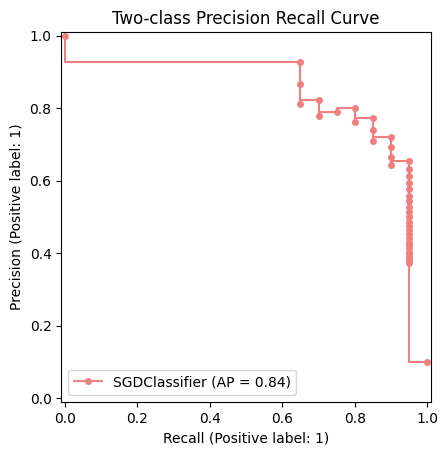

In [204]:
pos_rate_dispaly = PrecisionRecallDisplay.from_estimator(sgd_clf,
                                                         X_test,
                                                         y_test,
                                                         name="SGDClassifier",
                                                         marker="o",
                                                         markersize=4,
                                                         color="lightcoral")
_ = pos_rate_dispaly.ax_.set_title("Two-class Precision Recall Curve")

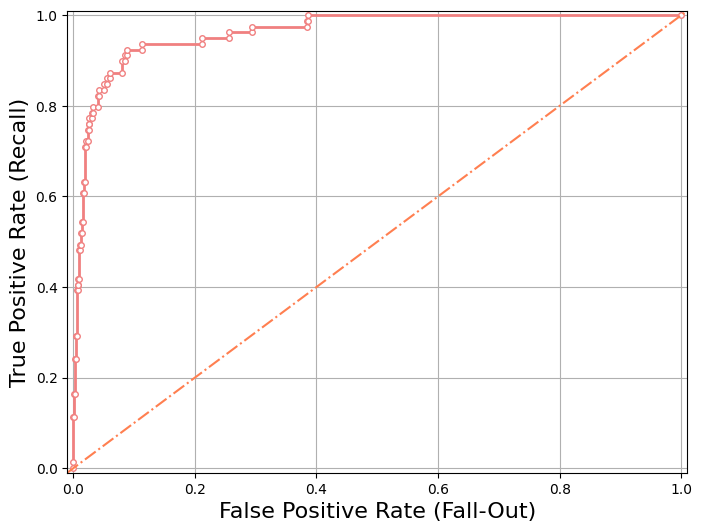

In [205]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, "o-", linewidth=2, label=label, color="lightcoral",
             markersize=4, markerfacecolor="white")
    plt.plot([-0.01, 1.01], [-0.01, 1.01], "coral", linestyle="-.")
    plt.axis([-0.01, 1.01, -0.01, 1.01])
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)
    plt.grid(True)
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
plt.show()

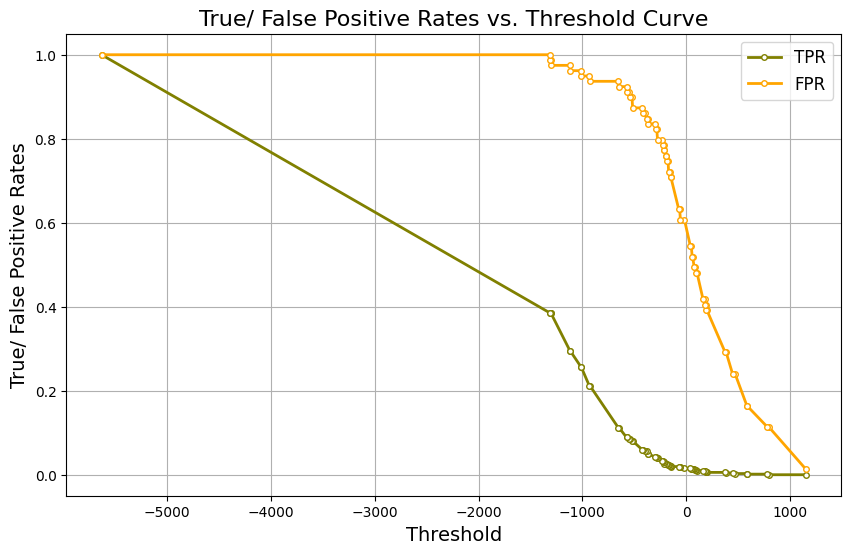

In [206]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fpr, "o-", linewidth=2, label="TPR", color="olive",
             markersize=4, markerfacecolor="white")
plt.plot(thresholds, tpr, "o-", linewidth=2, label="FPR", color="orange",
             markersize=4, markerfacecolor="white")
plt.title("True/ False Positive Rates vs. Threshold Curve", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("True/ False Positive Rates", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

In [207]:
auc = roc_auc_score(y_train, y_scores)
print("AUC:", auc)

AUC: 0.9634473919837075


## Model Developement - Clf One to Nine

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=2
                                                    )

In [209]:
clf = SGDClassifier(random_state=42, loss="log_loss")
clf.fit(X_train, y_train)
cross_val_score(clf, X_train, y_train, cv=10, scoring="accuracy")
y_pred = cross_val_predict(clf, X_train, y_train, cv=10)

In [210]:
first_digit = X_train.iloc[0]
first_digit_scores = clf.decision_function([first_digit])
first_digit_proba = clf.predict_proba([first_digit])
print("Classes: {}".format(clf.classes_))
print("Score for each class: {}".format(first_digit_scores[0]))
print("Probability for each class: {}".format(first_digit_proba[0]))
print("Class with the highest score: {}".format(np.argmax(first_digit_scores)))

Classes: [0 1 2 3 4 5 6 7 8 9]
Score for each class: [ -6378060.20415738  -5372741.43469605  -7546379.17195258
 -10551322.03929169    157220.37660639  -5930477.39872154
  -2353683.61768785  -4955375.2970421   -5471532.64607821
  -5746912.24258878]
Probability for each class: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Class with the highest score: 4


In [211]:
clf.predict_proba([first_digit])

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [212]:
search_space = {
    "n_estimators": [200, 300],
    "max_features": [300, 400],
    "max_depth": [10, 15]
    }
clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=clf, param_grid=search_space, cv=3,
                           scoring="accuracy", return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'max_depth': 10, 'max_features': 300, 'n_estimators': 200}
RandomForestClassifier(max_depth=10, max_features=300, n_estimators=200)


In [213]:
one_vs_one_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
one_vs_one_clf.fit(X_train, y_train)
print("First digit is predicted as = {}".format(one_vs_one_clf.predict([first_digit])))
print("Number of estimators = {}".format(len(one_vs_one_clf.estimators_)))
print("First two estimators = {}".format(one_vs_one_clf.estimators_[:2]))

First digit is predicted as = [4]
Number of estimators = 45
First two estimators = (SGDClassifier(random_state=42), SGDClassifier(random_state=42))


## Model Developement - Clf Multi Targets

In [214]:
Y = np.c_[y_train >= 7, y_train % 2 == 1]

In [215]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, Y)
fifth_digit = X_train.iloc[4]
clf.predict([fifth_digit])

array([[ True, False]])

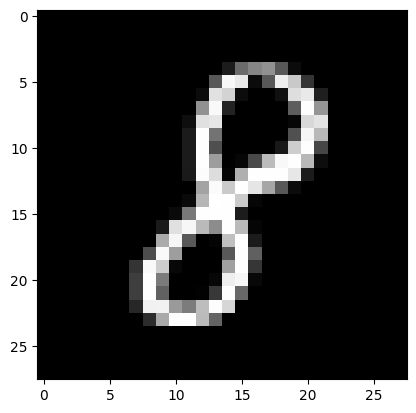

In [216]:
img = fifth_digit.to_numpy().reshape(pixel_size, pixel_size)
plt.imshow(img, cmap="gray")

In [217]:
accuracy_score = cross_val_score(clf, X_train, Y, cv=10)
y_pred = cross_val_predict(clf, X_train, Y, cv=10)

## Model Development - Batchify

In [236]:
X, y = mnist.data, mnist.target.to_frame()
y.columns = ['target']

In [237]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=2
                                                    )

In [239]:
%%time
batch_size = 32  # batch size
n_batches = len(X_train) // batch_size  # number of batches

clf = SGDClassifier()
for batch_index in range(n_batches):
    start = batch_index * batch_size
    end = (batch_index + 1) * batch_size
    X_batch = X_train[start:end]
    y_batch = y_train[start:end]
    clf.partial_fit(X_batch, y_batch, classes=np.unique(y))

CPU times: user 1min 47s, sys: 455 ms, total: 1min 47s
Wall time: 1min 50s


In [245]:
# predictions
y_pred = clf.predict(X_test)
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

Precision: 0.8835769627000595
Recall: 0.8798571428571429
F1-score: 0.8803540440125854


In [247]:
%%time
pred = cross_val_predict(clf, X_test, y_test, cv=5)

CPU times: user 1min 23s, sys: 811 ms, total: 1min 23s
Wall time: 1min 24s


In [248]:
print("precision: {}".format(precision_score(y_test, pred, average="macro")))
print("recall: {}".format(recall_score(y_test, pred, average="micro")))
print("f1: {}".format(f1_score(y_test, pred, average=None)))

precision: 0.8668347547500639
recall: 0.8689285714285714
f1: [0.9501637  0.95085066 0.82919813 0.81831086 0.88329686 0.78270849
 0.92533048 0.90940171 0.78143713 0.83712399]
